# Este código se refere ao Projeto Final da disciplina de Imagens Biomédicas, disciplina oferecida pela UNIFESP.


Um Instituto renomado no Brasil faz todos os tipos de investigações,
intervenções, tratamentos e pesquisas relacionados ao coração. Dentre
eles, estão as investigações das coronárias, estas investigações são
realizadas com um equipamento chamado Ultrassom Intravascular (IVUS).
Este equipamento adquire imagens de seções transversais da coronária
pela inserção e movimento de retirada de um cateter (Figura). Contudo,
além de não fornecer informações objetivas, como dimensões, este
equipamento fornece centenas de imagens de uma mesma seção, o que
dificulta muito a análise por segmentação manual.
O pesquisador de cardiologia, quem usa este equipamento para
orientar doutorandos em medicina, pediu a criação de um aplicativo para
esta tarefa. O objetivo é fazer a segmentação e cálculo da área da borda
media-adventícia (parede externa do vaso) em imagens de IVUS.

- Elaborar um método automático ou semiautomático, que faça a
segmentação do lúmen em imagens de IVUS(Figura Abaixo em azul).
Divida o método em 3 partes, Pré-processamento, Extração de
Características e Pós-processamento.
- Avaliar este método de acordo com a metodologia de VP(%), FP(%),
FN(%). Adicionalmente, usar as métricas Overlap Dice(OD(%)) e
Overlap Ratio(OR(%)) descritas abaixo. Para a avaliação, usar 20
imagens de IVUS com seus respectivos GoldStandads. Img0.pgm até
img19.pgm com gsmab0.pgm até gsmab19.pgm.
- Resultados Projeto → A nota referente aos resultados do trabalho
será equivalente ao OR (%)

---
## <center>Importando bibliotecas e organizando estrutura de armazenamento das imagens<center>


In [2]:
%%capture
%pip install opencv-python
%pip install scikit-image
%pip install numpy
%pip install matplotlib

In [3]:
import cv2
import scipy
import skimage
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
%matplotlib inline

In [4]:
images_path = './imagens/'
images = list()

for dir, _, files in os.walk(images_path):
    for file in files:
        if 'img' in file:
            images.append(
                {
                    'original': skimage.img_as_float(
                        cv2.imread(os.path.join(dir, file), 0)),
                    'original_flag1': skimage.img_as_float(cv2.imread(os.path.join(dir, file), 1)),
                    'gold_standard': skimage.img_as_float(
                        cv2.imread(os.path.join(dir, file.replace('img', 'gsmab'))), 0),
                    'name': file,
                    'original_path': os.path.join(dir, file),
                    'gold_standard_name': file.replace('img', 'gsmab'),

                })


## <center>Mostrando os 5 primeiros grupos de imagens<center>
---

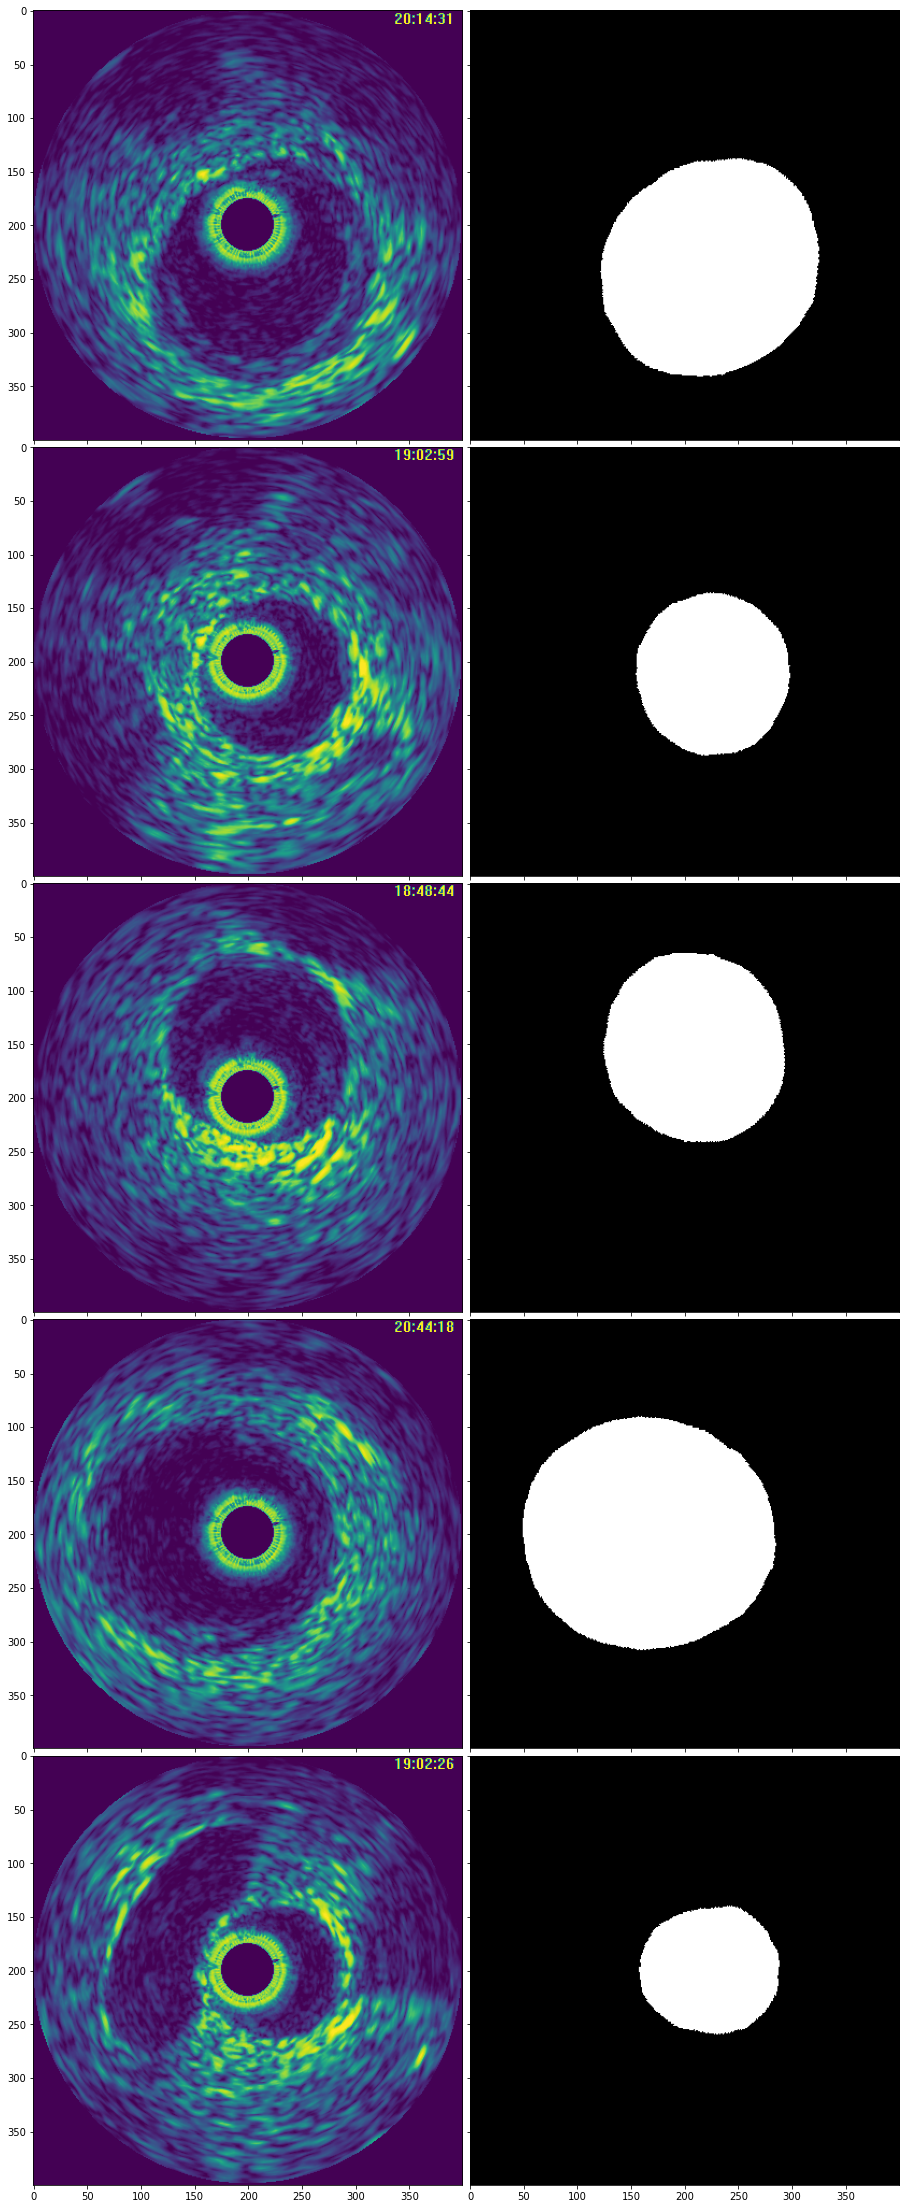

In [5]:
fig = plt.figure(1, (50., 40.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 2),
                 axes_pad=0.1,
                 )
for index, img in enumerate(images[0:5]):
    grid[0+(index*2)].imshow(images[index]['original'])
    grid[(index*2)+1].imshow(images[index]['gold_standard'])

---
## <center>PRÉ-PROCESSAMENTO</center>
---

### CRIANDO FUNÇÃO PARA FILTRAGEM

In [6]:
def fazer_mascara_ideal_2D(m, n, fc):
    h_ideal = np.zeros((m,n), complex)
    d0 = fc * (m/2)
    for l in range(m):
        for c in range(n):
            dist_c = c - (n/2)
            dist_l = l - (m/2)
            d = np.sqrt((dist_c ** 2) + (dist_l ** 2))
            if d < d0:
                h_ideal[l,c] = 1 + 0j
    return h_ideal
def fazer_mascara_gaussiana_2d(m, n, fc):
    h_gauss = np.zeros((m,n), complex)
    d0 = fc * (m/2)
    for l in range(m):
        for c in range(n):
            dist_c = c - (n/2)
            dist_l = l - (m/2)
            d = np.sqrt((dist_c ** 2) + (dist_l ** 2))
            h_gauss[l,c] = np.exp(-((d**2)/((2*d0) ** 2))) + 0j
    return h_gauss

### APLICANDO FILTROS

In [7]:
for image in images:
    name = image['name']
    print(f'Filtrando: {name}')
    # Capturando imagem
    img_original = image['original']
    # Capturando as dimensões da imagem
    (M,N) = np.shape(img_original)
    # Passando a imagem para domínio da frequência
    frequency_pulse = np.fft.fft2(img_original)
    # Espelhando frequência em 0
    shift_frequency = np.fft.fftshift(frequency_pulse)
    # Fazendo mascara guassiana
    mascara = fazer_mascara_gaussiana_2d(M,N, 0.15)
    # Aplicando a mascara
    img_frequency_filtered = shift_frequency * mascara
    # Transformada inversa
    image['img_filtered'] = np.fft.ifft2(img_frequency_filtered)

Filtrando: img11.pgm
Filtrando: img17.pgm
Filtrando: img13.pgm
Filtrando: img2.pgm
Filtrando: img15.pgm
Filtrando: img0.pgm
Filtrando: img6.pgm
Filtrando: img7.pgm
Filtrando: img18.pgm
Filtrando: img14.pgm
Filtrando: img10.pgm
Filtrando: img19.pgm
Filtrando: img1.pgm
Filtrando: img8.pgm
Filtrando: img3.pgm
Filtrando: img16.pgm
Filtrando: img9.pgm
Filtrando: img4.pgm
Filtrando: img5.pgm
Filtrando: img12.pgm


---
## <center>EXTRAÇÃO DE CARACTERÍSTICAS<center>
---

### CRIANDO FUNÇÃO DE SEGMENTAÇÃO SEMI-AUTOMÁTICA

In [8]:
def fazer_segmentacao_semente(stats: dict, image: dict):
    """_summary_

    Args:
        lst_x (_type_): _description_
        lst_y (_type_): _description_
        io (_type_): _description_

    Returns:
        _type_: _description_
    """
    lim_inf = stats.get('lim_inf')
    lim_sup = stats.get('lim_sup')
    seed_col = stats.get('seed_col')
    seed_lin = stats.get('seed_lin')

    io = image['original']
    img = image['original_flag1']

    lst_x, lst_y = list(), list()
    lst_x.append(seed_col)
    lst_y.append(seed_lin)
    # Criando uma imagem vazia
    obj = skimage.img_as_float(
        np.zeros(io.shape, np.uint8)
        )
    obj[seed_lin, seed_col] = 1
    cv2.line(img, (seed_col, seed_lin), (seed_col, seed_lin), (255, 0, 0), 5)
    (tamanho_fila, ) = np.shape(lst_y)

    while tamanho_fila > 0:
        seed_col = lst_x[0]
        seed_lin = lst_y[0]

        while (seed_col+1 > (N-1) or seed_col-1 < 0 or seed_lin+1>(M-1) or seed_lin-1 < 0):
            lst_x.remove(seed_col)
            lst_y.remove(seed_lin)
            (tamanho_file, ) = np.shape(lst_y)
            if tamanho_file==0:
                break
            else:
                seed_col = lst_x[0]
                seed_lin = lst_y[0]

        # Direita
        if (obj[seed_lin, seed_col+1] == 0) and (io[seed_lin, seed_col+1]>lim_inf and io[seed_lin, seed_col+1]<lim_sup):

            lst_x.append(seed_col+1)
            lst_y.append(seed_lin)

            cv2.line(img,(seed_col+1, seed_lin), (seed_col+1, seed_lin), (255,0,0), 5)
            obj[seed_lin, seed_col+1] = 1

        # Baixo
        if (
            obj[seed_lin+1, seed_col] == 0 and
            (io[seed_lin+1, seed_col]>lim_inf) and
            io[seed_lin+1, seed_col]< lim_sup
            ):
            lst_x.append(seed_col)
            lst_y.append(seed_lin+1)
            cv2.line(img, (seed_col, seed_lin+1), (seed_col, seed_lin+1), (255,0,0), 5)
            obj[seed_lin+1, seed_col] = 1

        # Cima
        if (
            obj[seed_lin-1, seed_col] == 0 and (io[seed_lin-1, seed_col]>lim_inf) and io[seed_lin, seed_col-1]<lim_sup
        ):
            lst_x.append(seed_col)
            lst_y.append(seed_lin-1)

            cv2.line(img, (seed_col, seed_lin-1), (seed_col, seed_lin-1), (255,0,0), 5)
            obj[seed_lin-1, seed_col] = 1

        # Esquerda
        if (
            obj[seed_lin, seed_col-1] == 0 and (io[seed_lin, seed_col-1]>lim_inf) and io[seed_lin, seed_col-1]<lim_sup
        ):
            lst_x.append(seed_col-1)
            lst_y.append(seed_lin)

            cv2.line(img, (seed_col-1, seed_lin), (seed_col-1, seed_lin), (255,0,0), 5)
            obj[seed_lin-1, seed_col] = 1
        if tamanho_fila == 0:
            break
        else:
            lst_x.remove(seed_col)
            lst_y.remove(seed_lin)
            (tamanho_fila, ) = np.shape(lst_y)
    return obj

### CAPTURANDO ROI E SEGMENTANDO

In [18]:
%%capture
for img in images:
    name = img['name']
    data = img['original']
    roi = cv2.selectROI(img=data, windowName=name)
    cv2.destroyAllWindows()
    schema = dict()
    schema['roi'] = roi
    schema['cmin'] = roi[0]
    schema['lmin'] = roi[1]
    schema['cmax'] = roi[0] + roi[2]
    schema['lmax'] = roi[1] + roi[3]
    img['roi_stats'] = schema


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by

In [22]:
for index, img in enumerate(images):
    name = img['name']
    if index > 5:
        break
    roi_stats = img['roi_stats']
    roi, lmin, lmax, cmin, cmax = roi_stats['roi'], roi_stats['lmin'], roi_stats['lmax'], roi_stats['cmin'], roi_stats['cmax']
    print(f'Segmentando {name}')
    data = img['original']
    stats = dict()
    stats['media'] = np.mean(data[lmin:lmax, cmin:cmax])
    stats['dp'] = np.std(data[lmin:lmax, cmin:cmax])
    stats['lim_sup'] = stats.get('media') + 3*stats.get('dp')
    stats['lim_inf'] = stats.get('media') - 3*stats.get('dp')
    stats['seed_lin'] = int(lmin + np.round(roi[3]/2))
    stats['seed_col'] = int(cmin + np.round(roi[2]/2))
    img['img_segmented'] = fazer_segmentacao_semente(stats, img)
    img['stats'] = stats


Segmentando img11.pgm
Segmentando img17.pgm
Segmentando img13.pgm
Segmentando img2.pgm
Segmentando img15.pgm
Segmentando img0.pgm


### Verificando estrutura gerada

In [23]:
print(images[0]['name'])
images[0]['stats']

img11.pgm


{'media': 0.04485404356645207,
 'dp': 0.034567109989154916,
 'lim_sup': 0.14855537353391682,
 'lim_inf': -0.05884728640101269,
 'seed_lin': 280,
 'seed_col': 234}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


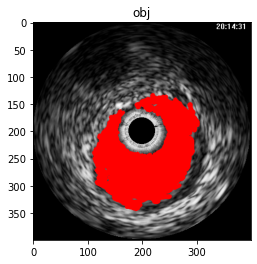

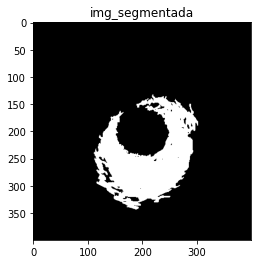

In [24]:
plt.figure()
plt.title('obj')
plt.imshow(images[0]['original_flag1'], cmap='gray')

plt.figure()
plt.title('img_segmentada')
plt.imshow(images[0]['img_segmented'], cmap='gray')

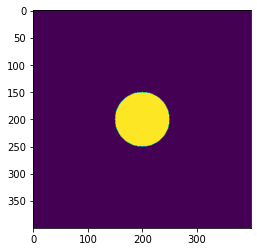

In [25]:
posicao_central = (200,200)
x, y = np.ogrid[0:N, 0:M]
circle_mask = (x - 200) ** 2 + (y - 200) ** 2 <= 50 ** 2
plt.imshow(circle_mask)

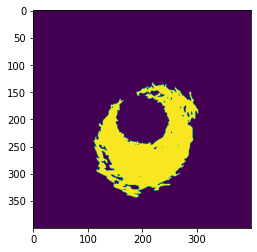

In [26]:
kkk = images[0]['img_segmented']
kkk[circle_mask] = kkk[circle_mask] + 0.01
plt.figure()
plt.imshow(kkk)

In [27]:
mask = kkk > 0

mask.shape

(400, 400)

In [28]:
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)


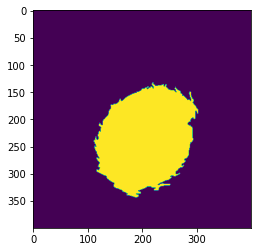

In [29]:
plt.imshow(mask)
mask_bord = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)

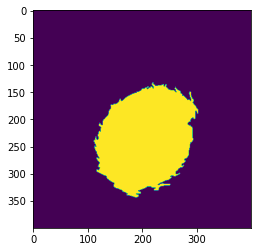

In [30]:
plt.imshow(mask_bord)


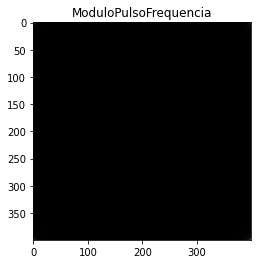

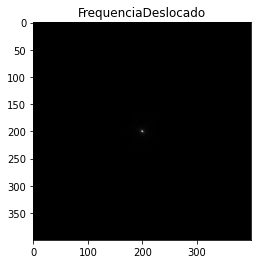

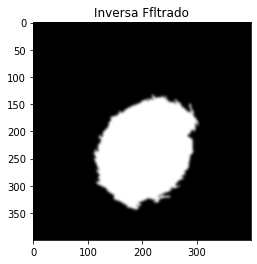

In [31]:
abc2 = mask
(M,N) = np.shape(abc2)

PulsoFrequencia = np.fft.fft2(abc2)
plt.figure()
plt.title('ModuloPulsoFrequencia')
plt.imshow(np.abs(PulsoFrequencia), cmap='gray')

FrequenciaDeslocado = np.fft.fftshift(PulsoFrequencia)
plt.figure()
plt.title('FrequenciaDeslocado')
plt.imshow(np.abs(FrequenciaDeslocado), cmap='gray')

mascara = fazer_mascara_gaussiana_2d(M,N, 0.1)

Ffiltrado = FrequenciaDeslocado * mascara
reverse_Ffiltrado = np.fft.ifft2(Ffiltrado)
plt.figure()
plt.title('Inversa Ffltrado')
plt.imshow(np.abs(reverse_Ffiltrado), cmap='gray')

In [32]:
X = skimage.morphology.disk(10)

In [33]:
objeto_segmentado_bin_close = skimage.morphology.binary_closing(mask_bord, X)


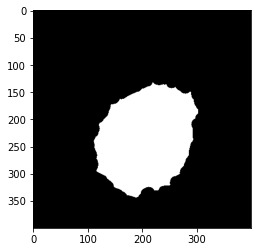

In [34]:
plt.imshow(objeto_segmentado_bin_close, cmap='gray')

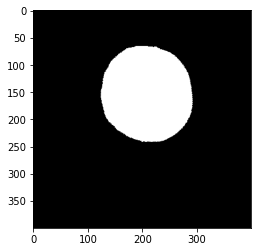

In [35]:
sduahu = cv2.imread('./imagens/gsmab13.pgm', 0)
plt.imshow(sduahu, cmap='gray')


In [36]:
def fazer_avaliacao_segmentacao(objeto_segmentado: np.array, gold_standard: np.array) -> tuple:
    objeto_segmentado: np.array = objeto_segmentado > 0.5
    gold_standard: np.array = gold_standard > 0.5
    (M, N) = np.shape(objeto_segmentado)
    area_imagem = M*N
    area_objeto_segmentado = np.sum(objeto_segmentado)
    area_objeto_gold_standard = np.sum(gold_standard)
    area_interseccao = np.sum(objeto_segmentado & gold_standard)
    VP = 100 * (area_interseccao / area_objeto_gold_standard)
    FP = 100 * (area_objeto_segmentado - area_interseccao) / (area_imagem-area_objeto_gold_standard)
    FN = 100 * (area_objeto_gold_standard - area_interseccao) / area_imagem
    return (VP, FP, FN)

In [37]:
(VP, FP, FN) = fazer_avaliacao_segmentacao(objeto_segmentado_bin_close, sduahu)

In [38]:
OD = (200*VP)/((2*VP)+FP+FN)

In [39]:
OD

84.12051258805083

In [40]:
OR = (100*VP)/(VP+FP+FN)

In [41]:
OR

72.59310035520278